<a href="https://colab.research.google.com/github/apla14/M1-2019/blob/master/M2_eksam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2 Eksamen

##Introduction 

In this following assignment we have attempted to make a spam filter for SMS spam. For the purpose of this we are using the NUS SMS corpus of ham and spam messages, the acquisition of which we will discuss later. Our intension is to set up both supervised machine learning models as well as attempting to find patterns in the data using unsupervised learning.

The unsupervised part will contain a topic detection model, followed by a clustering algorithm based on cosine similarity. The supervised part will contain a dimensionality reduction of both a training and testing dataset, as well as several different models for filtering spam messages (decision tree, random Forrest, generalized linear model).


## Description of data acquisition / how it was collected (by you or the publisher of the data)

The dataset is a set of SMS labeled messages which is collected for mobile phone spam research. The dataset is a collection of 5.574 real and non-enconded English messages. 
The dataset is a collection of various free research content on the Internet. For example, some of the spam messages come from a UK forum where you can report if the messages is spam. Additionally, some of ham messages are getting from the Institute of Computer Science at the National University of Singapore. All the messages is incorporated to our dateset " SMS Spam Collection."


## Definition of a problem statement and a short outline of the implementation

This project will be centralized around SMS messages and how Data Science can contribute to filtering out unwanted text messages. The overall problem is affiliated with the different types of SMS labeled messages with specific focus on "Spam" in SMS messages. Spam is generally associated with messages that contain advertisement, harrestment or general fraud. Spam messages often contain hidden links, with the intent of obtaining the users password,login informaton, bank information or credit card informartion. Spam messages are an extreme nuisance for the general population, which creates a clear problem concerning detecting these spam SMS messages. The overall goal of this project will be to discover how spam SMS messages differ from ordinary messages, so a proper model can be made for detecting and filtering out spam messages. This will done by firstly analyzing the messages and discovering topic detection throughout all the messages.****(skal vi skrive alt hvad vi gør eller ikke? hvad synes i?)


## Data preparation (general)

We load the majority of the packages needed for the analysis

In [0]:
install.packages("pacman")
library(pacman)
pacman::p_load(tidyverse,
               magrittr,
               SnowballC,
               corpus,
               quanteda,
               tidytext,
               tm,
               topicmodels,
               lsa,
               uwot, #for UMAP
               dbscan,# For density based clustering
               ggraph,
               igraph,
               text2vec,
               randomForest
              )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning message in utils::install.packages(package, ...):
“installation of package ‘topicmodels’ had non-zero exit status”Warning message in p_install(package, character.only = TRUE, ...):
“”Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘topicmodels’”Warning message in pacman::p_load(tidyverse, magrittr, SnowballC, corpus, quanteda, :
“Failed to install/load:
topicmodels”

In [0]:
SMSspam=read_delim("https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms", 
    ";",escape_double = FALSE, col_names = FALSE, 
    trim_ws = TRUE)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character()
)
Warning message:
“7 parsing failures.
 row col  expected     actual                                                                  file
1129  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
1442  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
2371  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
2435  -- 2 columns 15 columns 'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
3053  -- 2 columns 3 columns  'https://raw.githubusercontent.com/apla14/hello-world/master/SpamSms'
.... ... ......... .......... .....................................................................
See problems(...) for more details.
”

Firstly we inspect the data

In [0]:
SMSspam %>% head()

X1,X2
<chr>,<chr>
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
ham,Ok lar... Joking wif u oni...
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham,U dun say so early hor... U c already then say...
ham,"Nah I don't think he goes to usf, he lives around here though"
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"


We can observe two columns. One indicating whether a SMS is ham(a real legitimate message) or spam(advertising/harassment) and a second column showing the actual text message. These two columns are unnamed in the original dataset, so we add the column names accordingly below

In [0]:
SMSspam %<>% mutate(ID=rownames(SMSspam)) %>% select(ID,X1,X2) 
SMSspam %<>% mutate(ham_spam=X1) %>% mutate(SMS=X2) %>% select(-X1,-X2)
SMSspam %>% head()

ID,ham_spam,SMS
<chr>,<chr>,<chr>
1,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
4,ham,U dun say so early hor... U c already then say...
5,ham,"Nah I don't think he goes to usf, he lives around here though"
6,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"


Our next step is to unnest the tokens splitting each SMS up in individual words, then we look at the words used the most in the different texts. We expect to find a large number of words that can be classified as stop words, finding these we remove them and stem the dataset. Then we check for sparcity by removing sparce terms, at differing sparcity levels and we find that we have to accept a very large amount of sparcity which we will handel later, and then we construct a data term matrix.

In [0]:
data = SMSspam %>% unnest_tokens(word,SMS)
data %>% head()
data %>% group_by(word) %>% count() %>% arrange(desc(n)) %>% head()

ID,ham_spam,word
<chr>,<chr>,<chr>
1,ham,go
1,ham,until
1,ham,jurong
1,ham,point
1,ham,crazy
1,ham,available


word,n
<chr>,<int>
i,2300
to,2249
you,2149
a,1448
the,1335
u,1183


In [0]:
own_stopwords = tibble(word = c("gt","lt","ü","2","4"), lexicon="OWN")
data= data %>% anti_join(stop_words%>% bind_rows(own_stopwords),by="word") %>% mutate(word=wordStem(word))
data %>% group_by(word) %>% count() %>% arrange(desc(n)) %>% head()

word,n
<chr>,<int>
call,673
ur,395
free,282
dai,261
love,258
time,249


In [0]:
dtm = data %>%  count(ID, word) %>% cast_dtm(document =ID, term = word, value = n, weighting = tm::weightTf)

dtm

dtm %>% removeSparseTerms(sparse = .99)
dtm %>% removeSparseTerms(sparse = .999)
dtm %>% removeSparseTerms(sparse = .9999)

<<DocumentTermMatrix (documents: 5451, terms: 7417)>>
Non-/sparse entries: 35192/40394875
Sparsity           : 100%
Maximal term length: 42
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5451, terms: 78)>>
Non-/sparse entries: 8497/416681
Sparsity           : 98%
Maximal term length: 8
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5451, terms: 1159)>>
Non-/sparse entries: 24917/6292792
Sparsity           : 100%
Maximal term length: 17
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 5451, terms: 7417)>>
Non-/sparse entries: 35192/40394875
Sparsity           : 100%
Maximal term length: 42
Weighting          : term frequency (tf)

## Network Data - preparation

MANGLER

## Network analysis





..


# NLP
- EDA / simple frequency-based analysis
- Simple vectorization (BoW, Tf-idf)
- Topic modelling / Clustering (LDA / LSA)
- Embedding-model based vectorization (Word2Vec, Fasttext, GloVe)

Tf-idf which stands for term-frequency- inverse document frequency, measures how relevant a term is in given document and how often a words appear. The relevans of the word increase to the number of times a word appears, but is offset by the frequency of the word in the corpus.

In [0]:
sms_idf <- data %>% 
  count(ham_spam,word, sort = TRUE) %>% 
  bind_tf_idf(ham_spam, word, n)

sms_idf %>% 
  head()

ham_spam,word,n,tf,idf,tf_idf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
spam,call,379,0.5631501,1.1015829,0.6203565
ham,call,294,0.4368499,0.2615556,0.1142606
ham,ur,251,0.6354430,0.2615556,0.1662037
ham,love,248,0.9612403,0.2615556,0.2514178
ham,time,230,0.9236948,0.2615556,0.2415976
ham,dai,229,0.8773946,0.2615556,0.2294875


*TF:* Term frequency of a word shows how frequently words appear. If the document is long, then it is possible that a word would appear much more times than shorter ones. TF is intended thus: 
- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document). 

The figure shows that 'call' appears 379 times in spam and 294 times in ham. The term frequency for call is respectively 0.56 and 0.43.






*IDF:* Inverse document frequency shows how common or rare a word is in the document. If IDF is closer to 0, then the word is more common and if not then it will approach to 1. IDF can be calculated: 
- (the total number of documents/number of documents that contain a word and calculating the logarith). 

When we multiply the numbers for TF and IDF it gives TD-IDF score. If the score is high the more relevant is the word in the document.  





In [0]:
sms_idf %>% 
arrange(desc(tf_idf))  %>% 
head()
  

ham_spam,word,n,tf,idf,tf_idf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
spam,claim,115,1,1.101583,1.101583
spam,prize,94,1,1.101583,1.101583
spam,tone,85,1,1.101583,1.101583
spam,won,73,1,1.101583,1.101583
spam,150p,71,1,1.101583,1.101583
spam,guarante,51,1,1.101583,1.101583


We use descending order to get the numbers arranged from largest to the smallest numbers. 

we then construct a data feature matrix, that we promptly makes sparce now the dataset can be used for unsupervised learning.

In [0]:
#document - feature - matrix 
sms_dfm <-data %>%
count(ID, word) %>%
cast_dfm(document =ID, term =word, value =n)
sparse = Matrix::Matrix(sms_dfm,sparse = TRUE)

sms_dfm

#When the document-feature-matrix is created, we execute a LDA with the quanteda function textmodel_lsa():
sms_lsa <-sms_dfm %>%
textmodel_lsa(nd =5)
sms_lsa %>% glimpse()

sms_lsa_loading <-sms_lsa$docs %>%as.data.frame() %>%rownames_to_column(var ="ID") %>%as_tibble()
sms_lsa_loading %>%head()



Document-feature matrix of: 5,451 documents, 7,417 features (99.9% sparse).

List of 5
 $ sk             : num [1:5] 34.2 28.1 23.7 22.8 20
 $ docs           : num [1:5451, 1:5] -1.19e-03 -5.87e-02 -1.45e-04 -1.40e-02 -7.51e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:5451] "1" "10" "100" "1000" ...
  .. ..$ : NULL
 $ features       : num [1:7417, 1:5] -3.47e-05 -4.41e-05 -6.82e-04 -4.93e-04 -4.50e-03 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:7417] "amor" "buffet" "bugi" "cine" ...
  .. ..$ : NULL
 $ matrix_low_rank: num [1:5451, 1:7417] 1.96e-05 -1.30e-04 1.18e-06 9.50e-05 6.22e-07 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:5451] "1" "10" "100" "1000" ...
  .. ..$ : chr [1:7417] "amor" "buffet" "bugi" "cine" ...
 $ data           :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:35192] 0 0 3160 0 383 715 1141 1841 2673 4409 ...
  .. ..@ p       : int [1:7418] 0 1 3 10 17 31 32 39 140 175 ...
  .. ..@ Dim     : int [1:2] 5451 7417
  .. ..@ Dimnames:List of 2
  .. ..@ x       : num

ID,V1,V2,V3,V4,V5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.187007e-03,2.126374e-03,2.119954e-03,-0.0004722118,0.0029940137
10,-5.872433e-02,-1.667147e-02,-4.954157e-02,0.0405215259,-0.0132345199
100,-1.454873e-04,6.120718e-05,-4.932348e-05,0.0003372846,0.0003795642
1000,-1.400165e-02,2.884178e-02,1.434156e-03,-0.0129542770,0.0026251357
1001,-7.513273e-05,1.541918e-05,-6.718202e-05,0.0002223929,0.0002496870
1002,-3.079406e-04,3.845725e-04,2.661723e-04,-0.0001671042,0.0006136200


## LDA

With a dataset now ready to use we now want find out if we can identify topics in the dataset, we will be looking for 2 topics as we want to identify ham and spam separately. 

In [0]:
pacman::p_load(text2vec,topicmodels)

In [0]:
lda = sparse %>%   LDA(k = 2, method = "Gibbs", control = list(seed = 1337))


lda_beta <- lda %>%
  tidy(matrix = "beta") %>%
  group_by(topic) %>%
  arrange(topic, desc(beta)) %>%
  slice(1:10) %>%
  ungroup()

lda_beta %>% head()

lda_beta %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  group_by(topic, term) %>%
  arrange(desc(beta)) %>%
  ungroup() %>%
  ggplot(aes(term, beta, fill = as.factor(topic))) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  scale_x_reordered() +
  labs(title = "Top 10 terms in each LDA topic",
       x = NULL, y = expression(beta)) +
  facet_wrap(~ topic, ncol = 2, scales = "free")

In [0]:
lda_gamma <- lda %>%
  tidy(matrix = "gamma")

lda_gamma %>% head()

lda_gamma %>%
  ggplot(aes(gamma)) +
  geom_histogram() +
  scale_y_log10() +
  labs(title = "Distribution of probabilities for all topics",
       y = "Number of documents", x = expression(gamma))


lda_gamma %>%
  ggplot(aes(gamma, fill = as.factor(topic))) +
  geom_histogram(show.legend = FALSE) +
  facet_wrap(~ topic, ncol = 2) +
  scale_y_log10() +
  labs(title = "Distribution of probability for each topic",
       y = "Number of documents", x = expression(gamma))


top_topics <- tweets_lda %>%
  tidy(matrix = "gamma")  %>%
  group_by(document) %>%
  top_n(1, wt = gamma) %>%
  ungroup()

top_topics %>%
  count(topic)

In [0]:
sms_lsa_umap <- umap(sms_lsa_loading %>% column_to_rownames("ID"), 
                       n_neighbors = 15, metric = "cosine", min_dist = 0.01, scale = TRUE,
                       verbose = TRUE, n_threads = 8) 


13:17:05 UMAP embedding parameters a = 1.896 b = 0.8006
13:17:05 Read 5451 rows and found 5 numeric columns
13:17:05 Scaling to zero mean and unit variance
13:17:05 Kept 5 non-zero-variance columns
13:17:05 Using Annoy for neighbor search, n_neighbors = 15
13:17:05 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
13:17:07 Writing NN index file to temp file /tmp/Rtmpca6OiI/file7e6dfa359e
13:17:07 Searching Annoy index using 8 threads, search_k = 1500
13:17:09 Annoy recall = 98%
13:17:09 Commencing smooth kNN distance calibration using 8 threads
13:17:09 377 smooth knn distance failures
13:17:10 Initializing from normalized Laplacian + noise
13:17:10 Commencing optimization for 500 epochs, with 100358 positive edges
13:17:23 Optimization finished


n_neighbors controls how UMAP balances local versus global structure.
We use n_neighbors value to be 15, cause small values of n_neighbors to cencentrate
on local structure, while large values push UMAP to look at larger neighborhoods. 

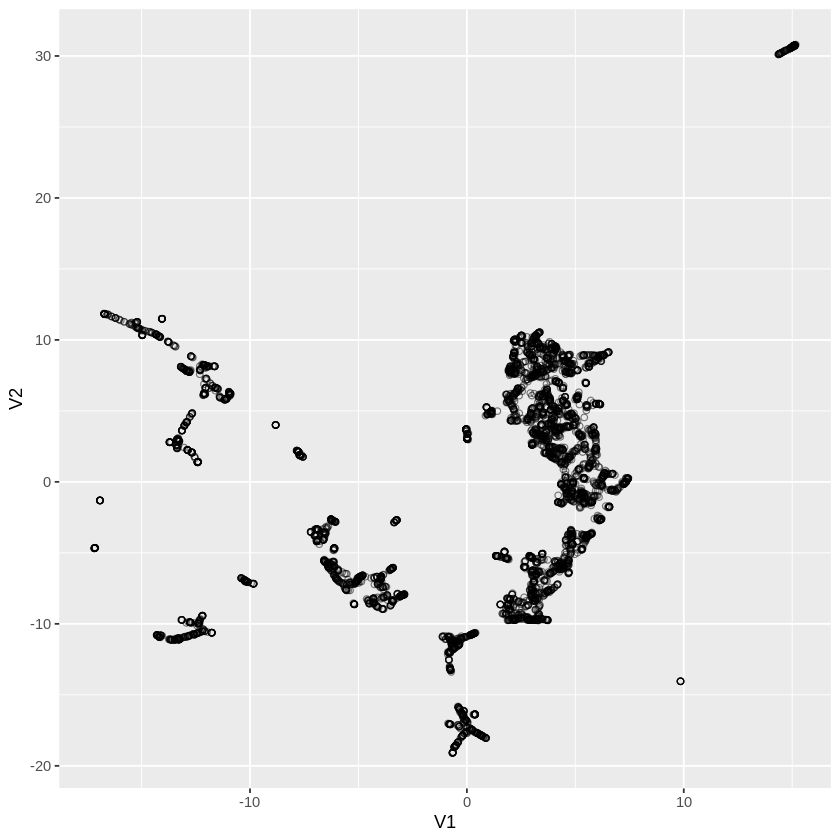

In [0]:
sms_lsa_umap %<>% as.data.frame()
sms_lsa_umap %>% 
  ggplot(aes(x = V1, y = V2)) + 
  geom_point(shape = 21, alpha = 0.5) 


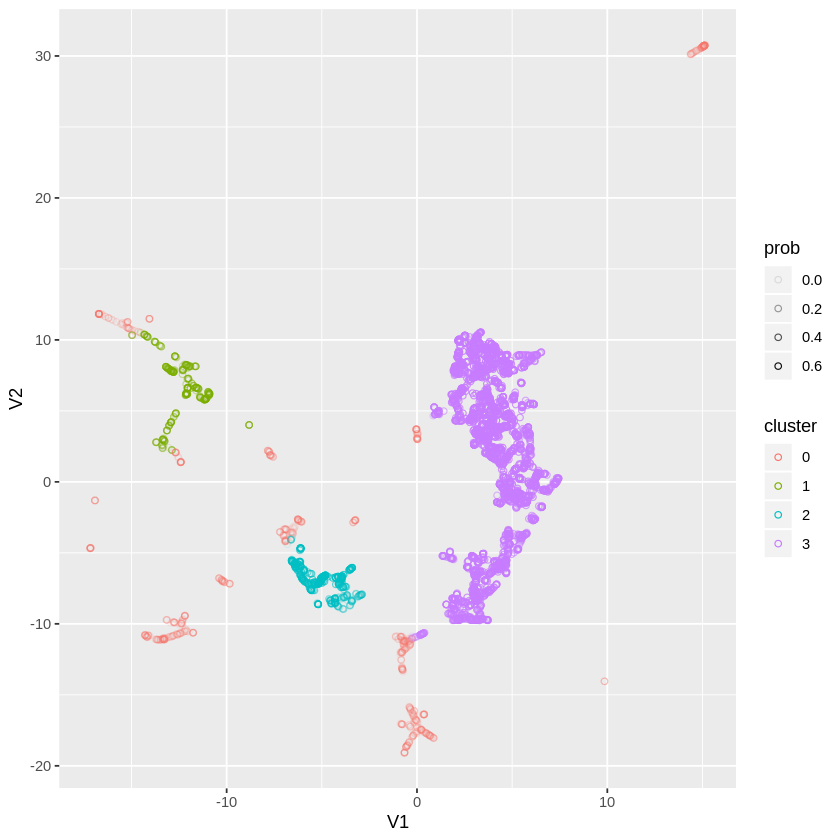

In [0]:
lsa_hdbscan <- sms_lsa_umap %>% as.matrix() %>% hdbscan(minPts = 400)

sms_lsa_umap %>%
  bind_cols(cluster = lsa_hdbscan$cluster %>% as.factor(),
            prob = lsa_hdbscan$membership_prob) %>%
  ggplot(aes(x = V1, y = V2, col = cluster)) +
  geom_point(aes(alpha = prob), shape = 21) 

UMAP is a non - linear dimension reduction algorithm. It’s trying to learn the manifold structure in our data and find a low dimensional embedding. The result show us, that the blue dots that are gathered around each other we assume to be ham messages, where the green ones are assumed to be spam messages.

## Supervised / Unsupervised ML

Earlier we made a datapreperation for our unsupervised machine learning part, now we are going to make a training and a test set and make a dimentionality reduction. First we will seperate the data using create data partition, and once again we tokenice and remove stopwords, and create a data frequency matrix.

In [0]:
pacman::p_load(caret,irlba)


# Use caret to create a 70%/30% stratified split. Set the random
# seed for reproducibility.
set.seed(32984)
indexes <- createDataPartition(as.factor(SMSspam$ham_spam), times = 1,
                               p = 0.7, list = FALSE)

train <- SMSspam[indexes,]
test <- SMSspam[-indexes,]




In [0]:
train_tokens = tokens(train$SMS, what = "word", 
                remove_numbers = TRUE, remove_punct = TRUE,
                remove_symbols = TRUE, remove_hyphens = TRUE)
train_tokens %>% head()

train_tokens = tokens_tolower(train_tokens)


train_tokens = tokens_select(train_tokens, stopwords(), 
                       selection = "remove")
train_tokens %>% head()

train_tokens = tokens_wordstem(train_tokens, language = "english")

train_tokens %>% head()

train_tokens.dfm <- dfm(train_tokens, tolower = FALSE)
train_tokens.dfm %>% head()

train_tokens.matrix <- as.matrix(train_tokens.dfm)
train_tokens.matrix %>% head()

train_tokens.df <- cbind(Label = train$ham_spam, convert(train_tokens.dfm,to = "data.frame"))
train_tokens.df




tokens from 6 documents.
text1 :
[1] "Ok"     "lar"    "Joking" "wif"    "u"      "oni"   

text2 :
 [1] "Free"     "entry"    "in"       "a"        "wkly"     "comp"    
 [7] "to"       "win"      "FA"       "Cup"      "final"    "tkts"    
[13] "21st"     "May"      "Text"     "FA"       "to"       "to"      
[19] "receive"  "entry"    "question" "std"      "txt"      "rate"    
[25] "T"        "C's"      "apply"    "s"       

text3 :
 [1] "U"       "dun"     "say"     "so"      "early"   "hor"     "U"      
 [8] "c"       "already" "then"    "say"    

text4 :
 [1] "Nah"    "I"      "don't"  "think"  "he"     "goes"   "to"     "usf"   
 [9] "he"     "lives"  "around" "here"   "though"

text5 :
 [1] "FreeMsg" "Hey"     "there"   "darling" "it's"    "been"    "week's" 
 [8] "now"     "and"     "no"      "word"    "back"    "I'd"     "like"   
[15] "some"    "fun"     "you"     "up"      "for"     "it"      "still"  
[22] "Tb"      "ok"      "XxX"     "std"     "chgs"    "to"      "se

tokens from 6 documents.
text1 :
[1] "ok"     "lar"    "joking" "wif"    "u"      "oni"   

text2 :
 [1] "free"     "entry"    "wkly"     "comp"     "win"      "fa"      
 [7] "cup"      "final"    "tkts"     "21st"     "may"      "text"    
[13] "fa"       "receive"  "entry"    "question" "std"      "txt"     
[19] "rate"     "t"        "c's"      "apply"    "s"       

text3 :
[1] "u"       "dun"     "say"     "early"   "hor"     "u"       "c"      
[8] "already" "say"    

text4 :
[1] "nah"    "think"  "goes"   "usf"    "lives"  "around" "though"

text5 :
 [1] "freemsg" "hey"     "darling" "week's"  "now"     "word"    "back"   
 [8] "like"    "fun"     "still"   "tb"      "ok"      "xxx"     "std"    
[15] "chgs"    "send"    "rcv"    

text6 :
[1] "even"    "brother" "like"    "speak"   "treat"   "like"    "aids"   
[8] "patent" 


tokens from 6 documents.
text1 :
[1] "ok"   "lar"  "joke" "wif"  "u"    "oni" 

text2 :
 [1] "free"     "entri"    "wkli"     "comp"     "win"      "fa"      
 [7] "cup"      "final"    "tkts"     "21st"     "may"      "text"    
[13] "fa"       "receiv"   "entri"    "question" "std"      "txt"     
[19] "rate"     "t"        "c"        "appli"    "s"       

text3 :
[1] "u"       "dun"     "say"     "earli"   "hor"     "u"       "c"      
[8] "alreadi" "say"    

text4 :
[1] "nah"    "think"  "goe"    "usf"    "live"   "around" "though"

text5 :
 [1] "freemsg" "hey"     "darl"    "week"    "now"     "word"    "back"   
 [8] "like"    "fun"     "still"   "tb"      "ok"      "xxx"     "std"    
[15] "chgs"    "send"    "rcv"    

text6 :
[1] "even"    "brother" "like"    "speak"   "treat"   "like"    "aid"    
[8] "patent" 


Document-feature matrix of: 6 documents, 5,706 features (99.8% sparse).

,ok,lar,joke,wif,u,oni,free,entri,wkli,comp,⋯,pshew,accent,4year,dental,nmde,dump,heap,ericsson,salesman,piti
text1,1,1,1,1,1,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
text2,0,0,0,0,0,0,1,2,1,1,⋯,0,0,0,0,0,0,0,0,0,0
text3,0,0,0,0,2,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
text4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
text5,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
text6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Label,document,ok,lar,joke,wif,u,oni,free,entri,⋯,pshew,accent,4year,dental,nmde,dump,heap,ericsson,salesman,piti
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ham,text1,1,1,1,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
spam,text2,0,0,0,0,0,0,1,2,⋯,0,0,0,0,0,0,0,0,0,0
ham,text3,0,0,0,0,2,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text4,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
spam,text5,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text6,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text7,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
spam,text8,0,0,0,0,1,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text9,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Next we set up a tfidf workflow and make a dimentionality reduction, saving it as train_svd and add a SpamSimilarity to the reduced dataset making a set ready for making the models.

In [0]:

train_term.frequency <- function(row) {
  row / sum(row)
}


train_inverse.doc.freq <- function(col) {
  corpus.size <- length(col)
  doc.count <- length(which(col > 0))
  
  log10(corpus.size / doc.count)
}


tf.idf <- function(x, idf) {
  x * idf
}

train_tokens.df <- apply(train_tokens.matrix, 1, train_term.frequency)

train_tokens.idf <- apply(train_tokens.matrix, 2, train_inverse.doc.freq)

train_tokens.tfidf <-  apply(train_tokens.df, 2, tf.idf, idf = train_tokens.idf)

train_tokens.tfidf <- t(train_tokens.tfidf)




In [0]:
train_incomplete.cases <- which(!complete.cases(train_tokens.tfidf))
train$SMS[train_incomplete.cases]

train_tokens.tfidf[train_incomplete.cases,] <- rep(0.0, ncol(train_tokens.tfidf))

train_tokens.tfidf.df <- cbind(Label = train$ham_spam, data.frame(train_tokens.tfidf))

train_tokens <- tokens_ngrams(train_tokens, n = 1:2)

train_irlba <- irlba(t(train_tokens.tfidf), nv = 300, maxit = 600)


train_sigma.inverse <- 1 / train_irlba$d
train_u.transpose <- t(train_irlba$u)
train_document <- train_tokens.tfidf[1,]
train_document.hat <- train_sigma.inverse * train_u.transpose %*% train_document

train_svd <- data.frame(Label = train$ham_spam, train_irlba$v)

train_similarities <- cosine(t(as.matrix(train_svd[, -c(1, ncol(svd))])))
pacman::p_load(lsa)

train_spam.indexes <- which(train$ham_spam == "spam")

train_svd$SpamSimilarity <- rep(0.0, nrow(train_svd))
for(i in 1:nrow(train_svd)) {
  train_svd$SpamSimilarity[i] <- mean(train_similarities[i, train_spam.indexes])  
}

[1] "What you doing?how are you?" "645"                        
[3] ":)"                          ":( but your not here...."

In [0]:
install.packages('e1071')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [0]:
library(e1071)

After setting up the training set we construct the reduced test set, the only difference from the training dimentionality reduction is that we force the training and test sets to have the same attributes using the dfm_select command with the pattern set to train_tokens.dtm.

In [0]:
test_tokens = tokens(test$SMS, what = "word", 
                remove_numbers = TRUE, remove_punct = TRUE,
                remove_symbols = TRUE, remove_hyphens = TRUE)
test_tokens %>% head()

test_tokens = tokens_tolower(test_tokens)


test_tokens = tokens_select(test_tokens, stopwords(), 
                       selection = "remove")
test_tokens %>% head()

test_tokens = tokens_wordstem(test_tokens, language = "english")

test_tokens %>% head()

test_tokens.dfm <- dfm(test_tokens, tolower = FALSE)
test.tokens.dfm <- dfm_select(test_tokens.dfm, pattern = train_tokens.dfm,
                              selection = "keep")

test_tokens.matrix <- as.matrix(test_tokens.dfm)


test_tokens.df <- cbind(Label = test$ham_spam, convert(test_tokens.dfm,to = "data.frame"))
test_tokens.df


tokens from 6 documents.
text1 :
 [1] "Go"        "until"     "jurong"    "point"     "crazy"     "Available"
 [7] "only"      "in"        "bugis"     "n"         "great"     "world"    
[13] "la"        "e"         "buffet"    "Cine"      "there"     "got"      
[19] "amore"     "wat"      

text2 :
 [1] "WINNER"   "As"       "a"        "valued"   "network"  "customer"
 [7] "you"      "have"     "been"     "selected" "to"       "receivea"
[13] "prize"    "reward"   "To"       "claim"    "call"     "Claim"   
[19] "code"     "Valid"    "hours"    "only"    

text3 :
 [1] "SIX"     "chances" "to"      "win"     "CASH"    "From"    "to"     
 [8] "pounds"  "txt"     "and"     "send"    "to"      "Cost"    "150p"   
[15] "day"     "6days"   "TsandCs" "apply"   "Reply"   "HL"      "info"   

text4 :
 [1] "I've"      "been"      "searching" "for"       "the"       "right"    
 [7] "words"     "to"        "thank"     "you"       "for"       "this"     
[13] "breather"  "I"         "promise" 

tokens from 6 documents.
text1 :
 [1] "go"        "jurong"    "point"     "crazy"     "available" "bugis"    
 [7] "n"         "great"     "world"     "la"        "e"         "buffet"   
[13] "cine"      "got"       "amore"     "wat"      

text2 :
 [1] "winner"   "valued"   "network"  "customer" "selected" "receivea"
 [7] "prize"    "reward"   "claim"    "call"     "claim"    "code"    
[13] "valid"    "hours"   

text3 :
 [1] "six"     "chances" "win"     "cash"    "pounds"  "txt"     "send"   
 [8] "cost"    "150p"    "day"     "6days"   "tsandcs" "apply"   "reply"  
[15] "hl"      "info"   

text4 :
 [1] "searching" "right"     "words"     "thank"     "breather"  "promise"  
 [7] "wont"      "take"      "help"      "granted"   "will"      "fulfil"   
[13] "promise"   "wonderful" "blessing"  "times"    

text5 :
 [1] "xxxmobilemovieclub"     "use"                    "credit"                
 [4] "click"                  "wap"                    "link"                  
 [7] "next"  

tokens from 6 documents.
text1 :
 [1] "go"     "jurong" "point"  "crazi"  "avail"  "bugi"   "n"      "great" 
 [9] "world"  "la"     "e"      "buffet" "cine"   "got"    "amor"   "wat"   

text2 :
 [1] "winner"   "valu"     "network"  "custom"   "select"   "receivea"
 [7] "prize"    "reward"   "claim"    "call"     "claim"    "code"    
[13] "valid"    "hour"    

text3 :
 [1] "six"    "chanc"  "win"    "cash"   "pound"  "txt"    "send"   "cost"  
 [9] "150p"   "day"    "6day"   "tsandc" "appli"  "repli"  "hl"     "info"  

text4 :
 [1] "search"   "right"    "word"     "thank"    "breather" "promis"  
 [7] "wont"     "take"     "help"     "grant"    "will"     "fulfil"  
[13] "promis"   "wonder"   "bless"    "time"    

text5 :
 [1] "xxxmobilemovieclub"     "use"                    "credit"                
 [4] "click"                  "wap"                    "link"                  
 [7] "next"                   "txt"                    "messag"                
[10] "click"           

Label,document,go,jurong,point,crazi,avail,bugi,n,great,⋯,hat,belt,cribb,yeh,kane,shud,flip,postcod,now1,bitch
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ham,text1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
spam,text2,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
spam,text3,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text4,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
spam,text5,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text6,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text7,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text8,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ham,text9,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [0]:
test_term.frequency <- function(row) {
  row / sum(row)
}


test_inverse.doc.freq <- function(col) {
  corpus.size <- length(col)
  doc.count <- length(which(col > 0))
  
  log10(corpus.size / doc.count)
}


tf.idf <- function(x, idf) {
  x * idf
}

test_tokens.df <- apply(test_tokens.matrix, 1, test_term.frequency)

test_tokens.idf <- apply(test_tokens.matrix, 2, test_inverse.doc.freq)

test_tokens.tfidf <-  apply(test_tokens.df, 2, tf.idf, idf = test_tokens.idf)

test_tokens.tfidf <- t(test_tokens.tfidf)


In [0]:
test_incomplete.cases <- which(!complete.cases(test_tokens.tfidf))
test$SMS[test_incomplete.cases]

test_tokens.tfidf[test_incomplete.cases,] <- rep(0.0, ncol(test_tokens.tfidf))

test_tokens.tfidf.df <- cbind(Label = test$ham_spam, data.frame(test_tokens.tfidf))

test_tokens <- tokens_ngrams(test_tokens, n = 1:2)

test_irlba <- irlba(t(test_tokens.tfidf), nv = 300, maxit = 600)


test_sigma.inverse <- 1 / test_irlba$d
test_u.transpose <- t(test_irlba$u)
test_document <- test_tokens.tfidf[1,]
test_document.hat <- test_sigma.inverse * test_u.transpose %*% test_document

test_svd <- data.frame(Label = test$ham_spam, test_irlba$v)

test_similarities <- cosine(t(as.matrix(test_svd[, -c(1, ncol(svd))])))
pacman::p_load(lsa)

test_spam.indexes <- which(test$ham_spam == "spam")

test_svd$SpamSimilarity <- rep(0.0, nrow(test_svd))
for(i in 1:nrow(test_svd)) {
  test_svd$SpamSimilarity[i] <- mean(test_similarities[i, test_spam.indexes])  
}


[1] "Where @"                     "What you doing?how are you?"
[3] ":-) :-)"

## GLOVE 

GloVe stands for Global Vector for Word Representation, and 
is an unsupervised learning algorithm, which we use for obtaining vector representations.
We contruct a new model for word representation we call glove for GlobalVectors, because the corpus are captured directly from the model.




In [0]:


# we create a Document - feature - matrix
feats <- train_tokens.dfm %>%
  dfm_trim(min_termfreq = 5) %>%
  featnames()


# we create a feature-co-occurence matrix.
sms_fcm <- fcm(train_tokens, 
                 context = "window", 
                 count = "weighted", 
                 weights = 1 / (1:5), 
                 tri = TRUE)




In [0]:
#Then we fit our model. 
glove <- GlobalVectors$new(word_vectors_size = 50, vocabulary = featnames(sms_fcm), x_max = 10)
sms_word_vectors <- fit_transform(sms_fcm, glove, n_iter = 20)

INFO [2019-10-24 14:16:31] 2019-10-24 14:16:31 - epoch 1, expected cost 0.0745
INFO [2019-10-24 14:16:31] 2019-10-24 14:16:31 - epoch 2, expected cost 0.0425
INFO [2019-10-24 14:16:31] 2019-10-24 14:16:31 - epoch 3, expected cost 0.0327
INFO [2019-10-24 14:16:31] 2019-10-24 14:16:31 - epoch 4, expected cost 0.0271
INFO [2019-10-24 14:16:31] 2019-10-24 14:16:31 - epoch 5, expected cost 0.0232
INFO [2019-10-24 14:16:31] 2019-10-24 14:16:31 - epoch 6, expected cost 0.0204
INFO [2019-10-24 14:16:32] 2019-10-24 14:16:32 - epoch 7, expected cost 0.0181
INFO [2019-10-24 14:16:32] 2019-10-24 14:16:32 - epoch 8, expected cost 0.0163
INFO [2019-10-24 14:16:32] 2019-10-24 14:16:32 - epoch 9, expected cost 0.0148
INFO [2019-10-24 14:16:32] 2019-10-24 14:16:32 - epoch 10, expected cost 0.0136
INFO [2019-10-24 14:16:32] 2019-10-24 14:16:32 - epoch 11, expected cost 0.0125
INFO [2019-10-24 14:16:32] 2019-10-24 14:16:32 - epoch 12, expected cost 0.0116
INFO [2019-10-24 14:16:32] 2019-10-24 14:16:32 - 

In [0]:
sms_word_vectors %<>% as.data.frame() %>%
  rownames_to_column(var = "word") %>% 
  as_tibble()

sms_word_vectors %>% head()

word,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ok,-0.11557385,-0.49504918,-0.16800553,-0.430785060,0.02588477,0.03791937,0.20872845,-0.34704530,0.20685500,⋯,0.02969530,0.09248274,0.3468129,-0.01049908,0.5550793,-0.76624441,-0.40975910,-0.02404179,0.23404874,-0.2290911
lar,0.11696773,-0.01425655,0.20711404,0.106203407,0.23670042,-0.31292954,-0.05282959,0.01810534,-0.14976604,⋯,-0.59400898,-0.07612772,0.1456196,-0.04728261,-0.1132914,-0.64686191,0.14582954,-0.36012715,0.34325087,0.7299292
joke,-0.52125555,0.34875733,-0.14563814,0.046417516,0.07389492,-0.51880789,0.04760320,-0.13671370,-0.40426052,⋯,-0.01274791,0.05498660,0.2505238,-0.30691019,-0.1643337,-0.02567438,-0.10988040,0.15283155,-0.22968256,-0.7204067
wif,0.30699039,-0.49194700,0.05065431,0.179026783,-0.45404166,-0.36385149,-0.41461277,-0.09054001,0.02936805,⋯,0.06616627,0.21433915,-0.2237084,-0.14255083,-0.4009939,-0.14125451,0.09177084,0.12533846,-0.07770040,-0.2084607
u,0.03367676,-0.11579362,0.05696568,-0.236513242,-0.37515023,-0.69529897,1.33124685,0.12428811,-0.20268612,⋯,0.21478814,0.35758415,-0.1947565,-0.38027626,0.7849444,-0.83795708,-0.37371999,-0.37426734,0.09935663,-0.1200828
oni,-0.29308030,0.26037142,-0.38360998,0.001864929,0.30813554,-0.05466937,-0.50262153,-0.18213201,-0.09831638,⋯,0.13152221,-0.21535563,0.3488511,0.26043868,0.4120965,-0.31673074,0.28684026,0.47301260,0.45624357,0.2485792


The results show interesting linear substructures of the order vector. This is achieved by taking the distance between the words that are semantically related.

In [0]:
set.seed(48743)
cv.folds <- createMultiFolds(train$ham_spam, k = 10, times = 1)

cv.cntrl <- trainControl(method = "repeatedcv", number = 10,
                         repeats = 1, index = cv.folds)



After making a dimensionality reduction with a corresponding train and test set, it is now time to construct models to predict whether a message is "ham" or "spam". The models will use the value of each word from the dimensionality reduction matrix to determine if a message is spam or not. The first model that will be constructed is a Generalized Linear Model, where the prediction is modeled as a weighted sum of the features. We construct the model below:

In [0]:
glm <- train(Label ~ ., data = train_svd, method = "glm", 
                trControl = cv.cntrl, tuneLength = 7,family=binomial())

After constructing the GLM model, it is time to test the model on the actual test dataset which we created earlier. 

In [0]:
pred = predict(glm,test_svd)

We continue to present the results in an actual confusion matrix to make it more presentable.

In [0]:
conf= table(test$ham_spam, pred)

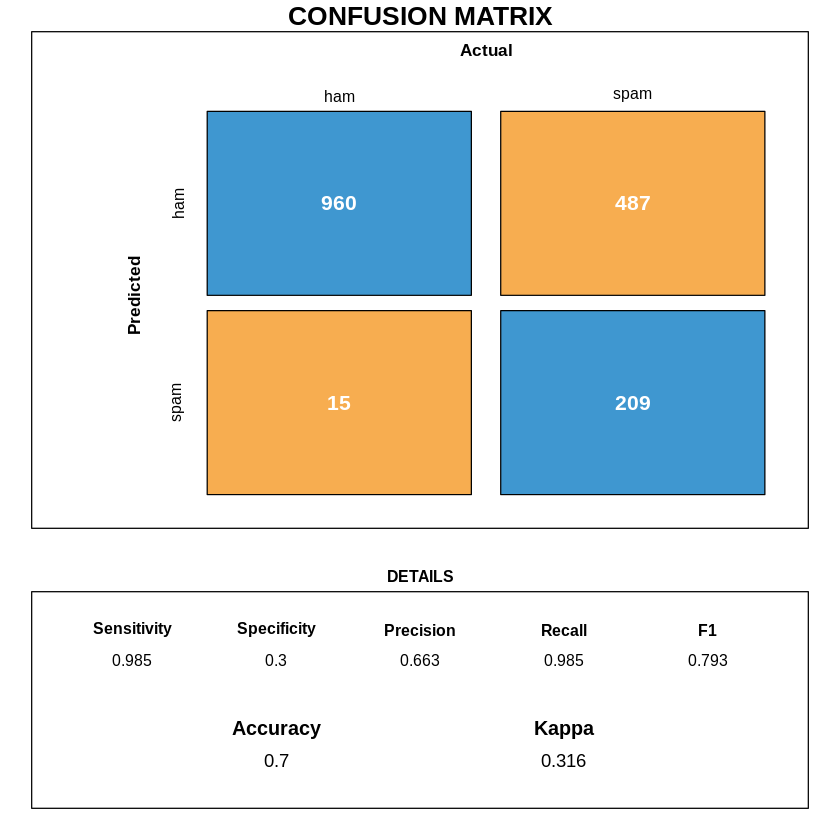

In [0]:
cm = confusionMatrix(conf)
draw_confusion_matrix <- function(cm) {
  
  total <- sum(cm$table)
  res <- as.numeric(cm$table)

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  classes = colnames(cm$table)
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'ham', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'spam', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'ham', cex=1.2, srt=90)
  text(140, 335, 'spam', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}
draw_confusion_matrix(cm)

GLM seems to be an ineffective model for predicting spam messages versus normal messages. The overall accuracy is 0.7% which is significantly low. The model classified 487 ham messages incorrectly as spam messages and determined 15 spam messages to be ham messages. A better and more suitable model is needed for this type of classification and therefore we try constructing a decision tree model

In [0]:
DT <- train(Label ~ ., data = train_svd, method = "rpart", 
                    trControl = cv.cntrl, tuneLength = 7)


After construction the model we test it on the same test dataset and present the results.

In [0]:
pred2 = predict(DT, test_svd)

In [0]:
conf2= table(test$ham_spam, pred2)

In [0]:
cm = confusionMatrix(conf2)

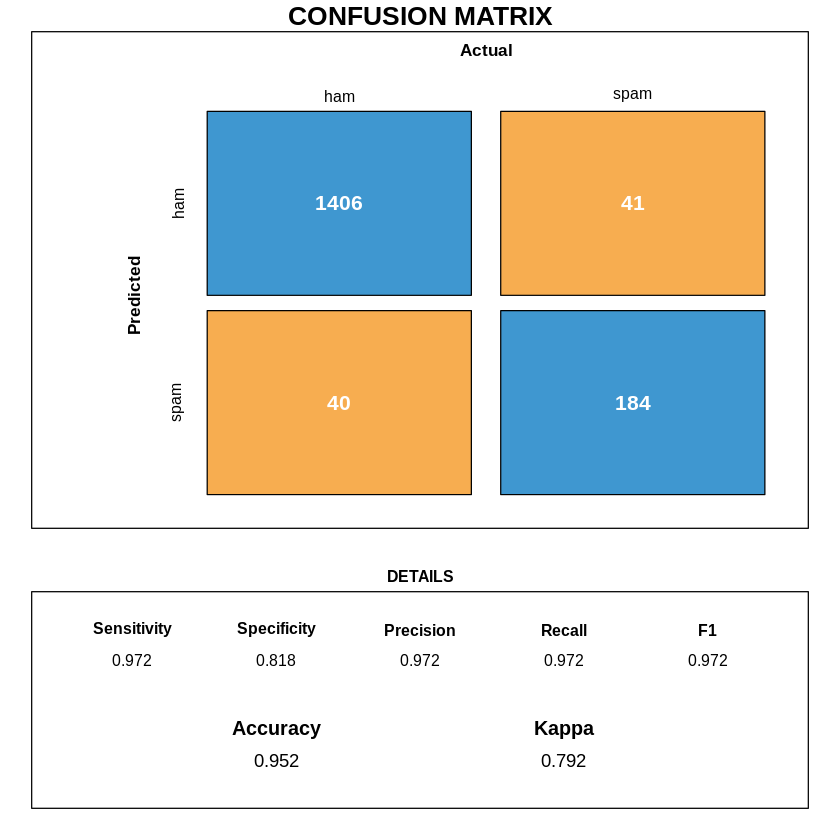

In [0]:
draw_confusion_matrix <- function(cm) {
  
  total <- sum(cm$table)
  res <- as.numeric(cm$table)

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  classes = colnames(cm$table)
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'ham', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'spam', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'ham', cex=1.2, srt=90)
  text(140, 335, 'spam', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}
draw_confusion_matrix(cm)

Decision Tree appears to be a more accurate and stable model with a high accuracy on 95%. This is significantly better then the previous GLM model and we can observe the model only classified 81 SMS messages incorrectly. Alternatively we could try constructing a random forest model which is a more advanced model compared to the original decision tree. Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction. We construct the model below and print out the results

In [0]:
RF <- train(Label ~ ., data = train_svd, method = "rf", 
                trControl = cv.cntrl, tuneLength = 7, ntree=25())

In [0]:
pred3 = predict(RF,test_svd)

In [0]:
conf3= table(test$ham_spam, pred3)

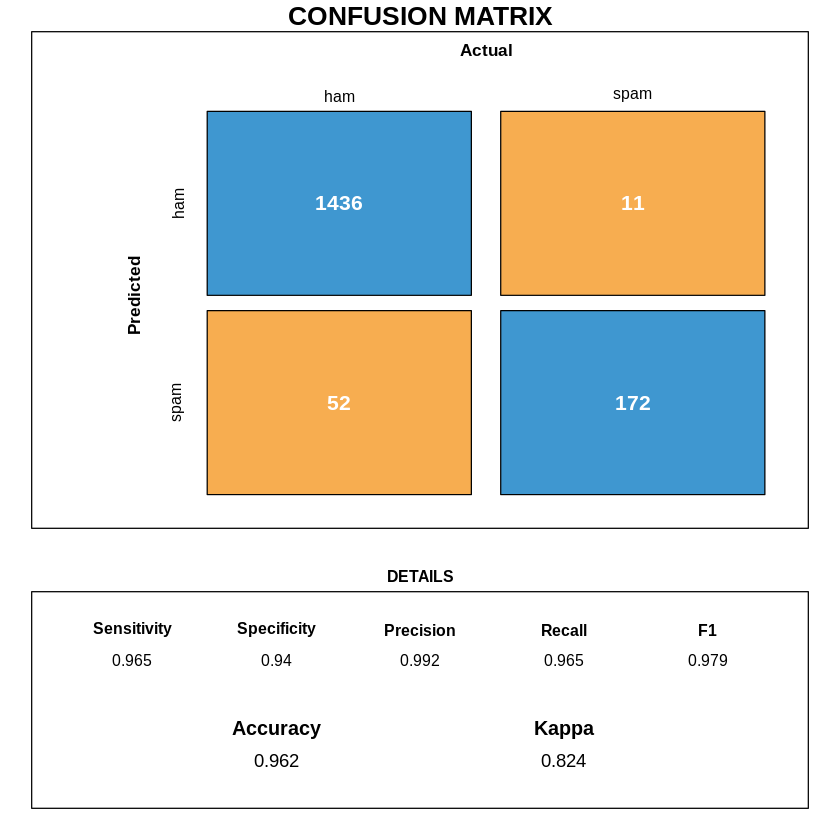

In [0]:
cm = confusionMatrix(conf3)
draw_confusion_matrix <- function(cm) {
  
  total <- sum(cm$table)
  res <- as.numeric(cm$table)

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  classes = colnames(cm$table)
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'ham', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'spam', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'ham', cex=1.2, srt=90)
  text(140, 335, 'spam', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
}
draw_confusion_matrix(cm)

The Random Forest model is the most accurate model with a accuracy on 96.22% beating both the decision tree and GLM model. The Random Forest model is better at classifying ham messages, where it only classified 11 ham messages falsely as spam. Overall it classified 63 SMS messages wrong out of 1671 messages and comes out as the superior model out of the three. 